# Amazon Rekognition Demo

***
Copyright [2017]-[2017] Amazon.com, Inc. or its affiliates. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License"). You may not use this file except in compliance with the License. A copy of the License is located at

http://aws.amazon.com/apache2.0/

or in the "license" file accompanying this file. This file is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
***

**Prerequisites:**

The user or role that executes the commands must have permissions in AWS Identity and Access Management (IAM) to perform those actions. AWS provides a set of managed policies that help you get started quickly. For our example, you need to apply the following minimum managed policies to your user or role:

* AmazonRekognitionFullAccess
* AmazonDynamoDBFullAccess
* AmazonS3FullAccess

Be aware that we recommend you follow AWS IAM best practices for production implementations, which is out of scope fof this workshop.



In [1]:
# initialise Notebook
import boto3
from IPython.display import HTML, display
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import time

# key variable initiation
rekognition = boto3.client('rekognition', region_name='us-east-1')
dynamodb = boto3.resource('dynamodb', region_name='us-east-1')
s3 = boto3.client('s3')

# blue, green, red, grey
colors = ((220,220,220),(242,168,73),(76,182,252),(52,194,123))

# helper function to lookup names in dynamoDB
actors = dynamodb.Table('rekognition_actors')
def get_actor_name(actorId):
    response = actors.get_item(
            Key={
                'actorId': actorId
            },
            AttributesToGet=['actorFullName']                  
        )
    
    if 'Item' in response:
        return (response['Item']['actorFullName'])
    else:
        return ('no match found in actors lookup')
    
# create Amazon DynamoDB table 
!aws dynamodb create-table --table-name rekognition_actors \
--attribute-definitions AttributeName=actorId,AttributeType=S \
--key-schema AttributeName=actorId,KeyType=HASH \
--provisioned-throughput ReadCapacityUnits=1,WriteCapacityUnits=1 \
--region us-east-1   

# create temporary directory
!mkdir tmp


An error occurred (ResourceInUseException) when calling the CreateTable operation: Table already exists: rekognition_actors
mkdir: cannot create directory 'tmp': File exists


## Object and scene detection

This features allows you to detect thousands of objects, scenes and concepts in your images and provide labels describing the objects detected.

This example presents an image to the object and scene detection endpoint to determine the lables for the image. 

In [2]:
bucket = 'mlrekognitiondemo-20180516'
key = 'images/demo1.jpg'
#key = 'images/P4050012.JPG'

# Download image from Amazon S3 for display
image_location = 'tmp/image'
s3.download_file(bucket, key, image_location)
image_bin=Image.open(image_location)

# retrieve labels from Amazon Rekognition service
ret = rekognition.detect_labels(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key,
        }
    },
    #MaxLabels=10,
    # MinConfidence=85
)

inner = "<table>"
for i in ret['Labels']:
    inner += "<tr><td>" + i['Name'] + "</td><td>" + str(i['Confidence']) + "</td></tr>"
display(HTML("<table><tr><td width='50%'><img src='tmp/image?"+str(time.time())+"' ></td><td> \
                "+inner+"</table></td></tr></table>"))  

## Facial analysis

Using Amazon DetectFaces API, you can detect faces in an image and key facial characteristics.

As faces are detected on an image you get a number of attributes about the face:

	- gender
	- age
	- sentiment of the person
    - coordinates of key features
    - image quality
    - etc.


In [3]:
bucket = 'mlrekognitiondemo-20180516'
key = 'images/WernerVogels.JPG'
OUTPUT_BLACKLIST = ("BoundingBox","Landmarks","Pose","Confidence")

# detect faces using Amazon Rekognition detect faces API
ret = rekognition.detect_faces(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key,
        }
    },
    Attributes=['ALL'],
)

# Output image and labels

image_location = 'tmp/image'
s3.download_file(bucket, key, image_location)

inner = "<table>"
for line in ret['FaceDetails']:   
    for label in line.keys():
        if not label in OUTPUT_BLACKLIST:
            if not type(line[label]) is list:
                inner += "<tr><td>" + label + "</td><td>" + str(line[label]) + "</td></tr>"
            elif type(line[label]) is list:    
                inner += "<tr><td><b>" + label + ":</b></td><td>" + '' + "</td></tr>"
                for entities in line[label]:
                    inner += "<tr><td>" + '' + "</td><td>" + str(entities) + "</td></tr>"

display(HTML("<table><tr><td width='40%'><img src='tmp/image?"+str(time.time())+"' ></td><td> \
                "+inner+"</table></td></tr></table>")) 


In [4]:
# Detect multiple faces within images

bucket = 'mlrekognitiondemo-20180516'
key = 'images/demo2.jpg'

# retrieve face boxes from Rekognition service

ret = rekognition.detect_faces(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key,
        }
    },
    Attributes=['DEFAULT'],
)

boxes = []

# Output labels

faces = ret['FaceDetails']
for face in faces:
    boxes.append (face['BoundingBox'])

# donwload image from S3
image_location ='tmp/image'
s3.download_file(bucket, key, image_location)

image_out = Image.open("tmp/image")

# apply face boxes to image 
draw = ImageDraw.Draw(image_out)
width, height = image_out.size
col = 0
line= 10
inner = "<table>"
for box in boxes:
    inner += "<tr><td><b>Face " + str(col+1) + ":<b></td><td>"
    x1 = int(box['Left'] * width)
    y1 = int(box['Top'] * height)
    x2 = int(box['Left'] * width + box['Width'] * width)
    y2 = int(box['Top'] * height + box['Height']  * height)
    for label in box.keys():
        inner += "<tr><td>" + label + "</td><td>" + str(box[label]) + "</td></tr>"
        
    for l in range(line):
        draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
    col += 1

image_out.save('tmp/image',format="PNG")
   
#display(image_out)

display(HTML("<table><tr><td width='60%'><img src='tmp/image?"+str(time.time())+"' ></td><td> \
                "+inner+"</table></td></tr></table>"))


## Face comparison

Given two images with faces, Rekognition will compare the largest face from the source image and find similarity with faces found in the target image. 


In [5]:
# retrieve and resize images for display

bucket = 'mlrekognitiondemo-20180516'
key1 = 'images/WernerVogels.JPG'
key2 = 'images/demo4.jpg'

s3.download_file(bucket, key1, 'tmp/image1')
s3.download_file(bucket, key2, 'tmp/image2')

# Compare faces using Rekognition

ret = rekognition.compare_faces(
    SourceImage={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key2,
        }
    
    },
    TargetImage={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key1,
        }    
    }
)

# And highlight match on the image

image_out = Image.open("tmp/image1")
draw = ImageDraw.Draw(image_out)

# get image size
width, height = image_out.size

col = 2
line= 5

box= ret['FaceMatches'][0]['Face']['BoundingBox']
x1 = int(box['Left'] * width)
y1 = int(box['Top'] * height)
x2 = int(box['Left'] * width + box['Width'] * width)
y2 = int(box['Top'] * height + box['Height']  * height)
        
for l in range(line):
        draw.rectangle((x1-l,y1-l,x2+l,y2+l),outline=colors[col])
    
image_out.save('tmp/image',format="PNG") 

inner = "<table>"
inner += "<tr><td><b>Face match:<b></td><td>"
inner += "<tr><td>Similarity: </td><td>" + str(ret['FaceMatches'][0]['Similarity']) + "</td></tr>"
for label in box.keys():
        inner += "<tr><td>" + label + "</td><td>" + str(box[label]) + "</td></tr>"

display(HTML("<table><tr><td><img src='tmp/image2' height='250' width='250'></td><td><img src='tmp/image' height='250' width='250'></td><td>"+inner+"</table></td></tr></table>"))



## Face recognition

With FaceRekognition, you can search your image collection for similar faces by storing faces, using the IndexFaces API operation. 
You can then use the SearchFaces operation to return high-confidence matches. A face collection is an index of faces that you own and manage.




In [6]:
%%bash
aws rekognition create-collection --collection-id actors --region us-east-1


An error occurred (ResourceAlreadyExistsException) when calling the CreateCollection operation: The collection id: actors already exists


In [7]:
# load face definitions into index

faces = [
{"objectId":"images/ChrisHemsworth1.jpg","actorFullName":"Chris Hemsworth"},
{"objectId":"images/ChrisHemsworth2.jpg","actorFullName":"Chris Hemsworth"},
{"objectId":"images/ChrisHemsworth3.jpg","actorFullName":"Chris Hemsworth"},    
{"objectId":"images/ElizabethOlsen1.jpg","actorFullName":"Elizabeth Olsen"},   
{"objectId":"images/ElizabethOlsen2.jpg","actorFullName":"Elizabeth Olsen"}, 
{"objectId":"images/ElizabethOlsen3.jpg","actorFullName":"Elizabeth Olsen"},      
{"objectId":"images/RobertDowneyJr1.jpg","actorFullName":"Robert Downey Jr"},
{"objectId":"images/RobertDowneyJr2.png","actorFullName":"Robert Downey Jr"},
{"objectId":"images/RobertDowneyJr3.jpg","actorFullName":"Robert Downey Jr"},   
]

s3_image_bucket = 'mlrekognitiondemo-20180516'
face_table = dynamodb.Table('rekognition_actors')

# function to write reference table in DynamoDB
def populate_lookup_table(actorFullName,actorId):
    print ('Populating DynamoDB index for ' + actorFullName + ' as ' + actorId)
    response = face_table.put_item(
                Item={
                      'actorId': actorId,
                      'actorFullName': actorFullName,
                      }
                )
    return response
        
def populate_rekognition_collection(objectId):
    ret = rekognition.index_faces(
    CollectionId=rekognition_face_index,
    Image={
                'S3Object': {
                    'Bucket': s3_image_bucket,
                    'Name':  objectId
                }
            }
        )
    if ret['ResponseMetadata']['HTTPStatusCode'] == 200:
        return ret['FaceRecords'][0]['Face']['FaceId']
    else:
        return False
    

# function to populate faces into index
def populate_index(all_faces,rekognition_face_index):
    for f in all_faces:
        ret = populate_rekognition_collection(f['objectId'])
        if ret == False:
            print ('some error')
        else:
            ret = populate_lookup_table(f['actorFullName'],ret)
        
              
    print ('done')



    
rekognition_face_index = 'actors' 
populate_index(faces,rekognition_face_index)


Populating DynamoDB index for Chris Hemsworth as 4593ff4d-7338-4db1-8c07-d3fce81b1459
Populating DynamoDB index for Chris Hemsworth as e8d328d1-8bc4-4e83-aeda-5260df8ec3d3
Populating DynamoDB index for Chris Hemsworth as e65d7acc-a980-4ade-8a2d-bdd294cbc6d1
Populating DynamoDB index for Elizabeth Olsen as 7e833425-b0f0-4191-8a5c-fb60fa151899
Populating DynamoDB index for Elizabeth Olsen as e175199b-d560-455d-8c70-1a570aaa86b8
Populating DynamoDB index for Elizabeth Olsen as f2e32281-a13a-4b7c-92b4-137e7dc77322
Populating DynamoDB index for Robert Downey Jr as ebf9ba52-4e51-4937-8c43-853e542b890a
Populating DynamoDB index for Robert Downey Jr as d6a10054-524f-4927-8197-746abcaf9d2d
Populating DynamoDB index for Robert Downey Jr as a6d77575-9b73-4698-ba73-754ea8422a9a
done


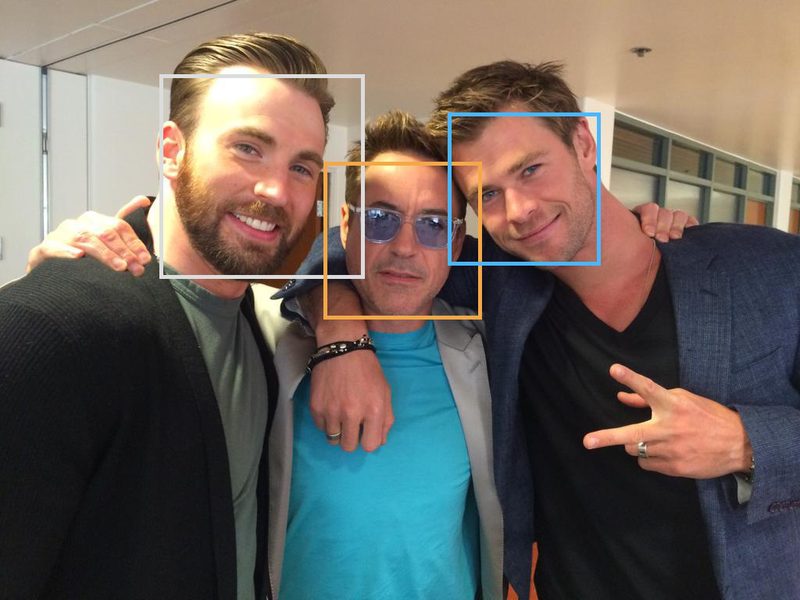

In [8]:

sourceurl = 'https://www.pinterest.com/pin/431993789236953158/'
#source = 'obs/Amazon.de/www.stephan-rabold.com'
imgurl = 'https://i.pinimg.com/originals/7f/68/88/7f68885efaad2e248181aae3ac49cf66.jpg'

bucket = 'mlrekognitiondemo-20180516'
key1 = 'images/demo7.jpg'

# open image
s3.download_file(bucket, key1, 'tmp/image')
image_bin=Image.open('tmp/image')

# resize image for display
image_out=Image.open('tmp/image')
size = 900,600
image_out.thumbnail(size, Image.ANTIALIAS)

# add resized image to image to stream and file for later processing
stream = BytesIO()
image_bin.save(stream,format="JPEG")
image_binary = stream.getvalue()
image_bin.save('tmp/image',format="JPEG")

# Detect face boxes using Rekognition

def face_detection(image_input):
    response = rekognition.detect_faces(
        Image={
            'Bytes':image_input
        }                                        
        )
    all_faces=response['FaceDetails']
    
    # initialise list object 
    boxes = []
  
    # populate list for each face
    for face in all_faces:
        boxes.append (face['BoundingBox'])
    return boxes

boxes = face_detection(image_binary)

# And highlight them on the image

image_out = Image.open("tmp/image")
draw = ImageDraw.Draw(image_out)

# get image size
width, height = image_out.size
 
# apply face boxes to image and store coordinates for later processing
def get_coordinates(face_boxes, image_width, image_height):
    # initialise list object 
    coordinates = [] 
    for box in face_boxes:
        x1 = int(box['Left'] * image_width)-5
        y1 = int(box['Top'] * image_height)-5
        x2 = int(box['Left'] * image_width + box['Width'] * image_width)+5
        y2 = int(box['Top'] * image_height + box['Height']  * image_height)+5
        if x1 < 0 : x1=0
        if y1 < 0 : y1=0
        if x2 < 0 : x2=image_width
        if y2 < 0 : y2=image_height 
            
        coordinates.append((x1,y1,x2,y2))
        
    return coordinates
    

coordinates = get_coordinates(boxes,width,height)
    
col = 0
line= 5     
for xy in coordinates: 
    for l in range(line):
        draw.rectangle((xy[0]-l,xy[1]-l,xy[2]+l,xy[3]+l),outline=colors[col])
    col += 1
        
size = 900,600
image_out.thumbnail(size, Image.ANTIALIAS)        

display(image_out)


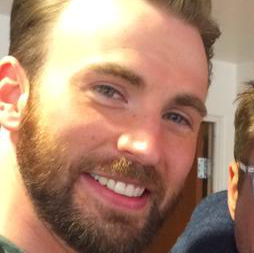

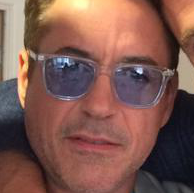

ebf9ba52-4e51-4937-8c43-853e542b890a 99.99949645996094 Robert Downey Jr


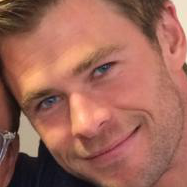

4593ff4d-7338-4db1-8c07-d3fce81b1459 100.0 Chris Hemsworth
e65d7acc-a980-4ade-8a2d-bdd294cbc6d1 99.99729919433594 Chris Hemsworth
e8d328d1-8bc4-4e83-aeda-5260df8ec3d3 99.99430084228516 Chris Hemsworth


In [9]:
# Search faces in index

def get_face_data(image_binary):
    
    try:
        response = rekognition.search_faces_by_image(
            CollectionId='actors',
            Image={
                'Bytes':image_binary
            }
            )
    
        if len(response['FaceMatches']) > 0:
            for o in response['FaceMatches']:
                print (o['Face']['FaceId'],o['Face']['Confidence'],get_actor_name(o['Face']['FaceId']))
            return response['FaceMatches'][0]['Face']['FaceId'],response['FaceMatches'][0]['Face']['Confidence']
        else:
            return ('no match detected',0)
    except Exception as e:
        #print (e)
        return ('no face detected',0)
        
    
# initialise list object 
ret = []    

# iterate through list of boxes and detect individual face
for box in coordinates:
        
        image_crop = image_bin.crop(box)
        display (image_crop)
        
        # add cropped image to temporary stream
        stream2 = BytesIO() 
        image_crop.save(stream2,format="JPEG")
        image_region_binary = stream2.getvalue()    
        stream2.close()
        
        try:
            # get external ID name of cropped image
            retdata=get_face_data(image_region_binary),box
            ret.append (retdata)            
        except Exception as e:
            print (e, box)
            ret.append ((('no face',0),box))
            pass


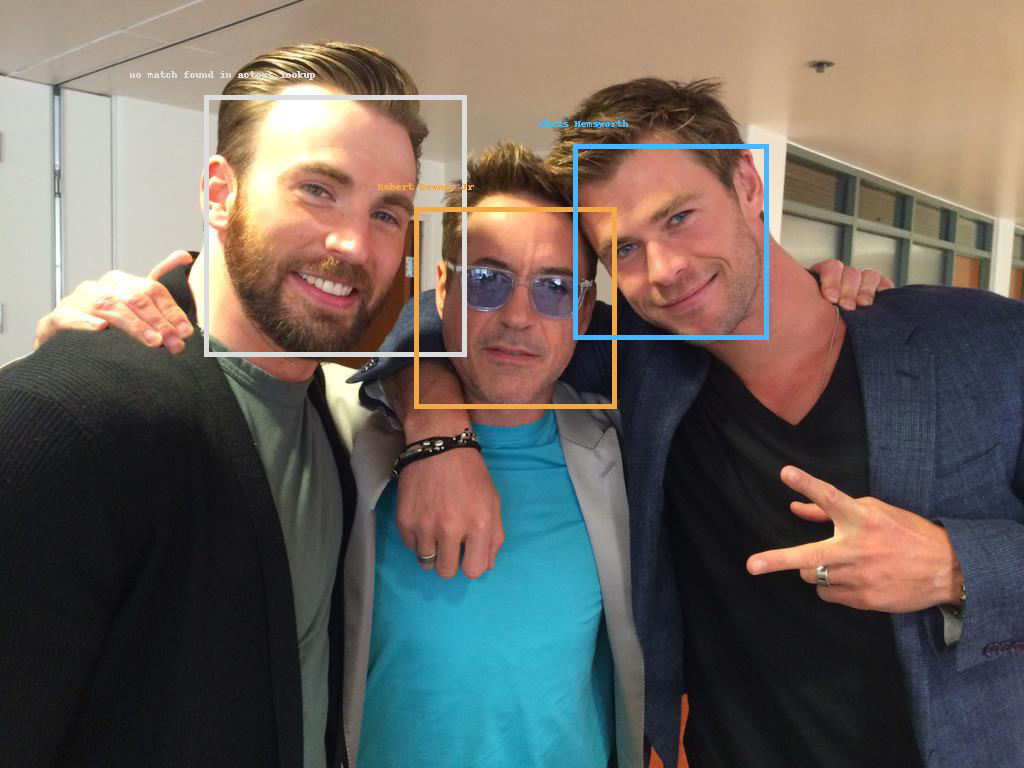

In [10]:
# Output matches on image

font = ImageFont.load_default()
img_out = Image.open("tmp/image")
draw = ImageDraw.Draw(img_out)

#font = ImageFont.truetype("/Library/Fonts/Arial.ttf", 22)

col = 0
xpos = 0
ypos = 30
line = 5
for f in ret:
    
    actor_name=get_actor_name(f[0][0]) 
    xpos = len(actor_name)*2.5
    draw.text((f[1][0]-xpos,f[1][1]-ypos),actor_name,colors[col],font=font)
    for l in range(line):
        draw.rectangle((f[1][0]-l,f[1][1]-l,f[1][2]+l,f[1][3]+l),outline=colors[col])
    col += 1
    
display(img_out)

## Celebrity detection

Amazon Rekognition can recognize thousands of celebrities in a wide range of categories, such as entertainment and media, sports, business, and politics.

In [11]:
%%bash

aws rekognition recognize-celebrities \
--image '{"S3Object":{"Bucket":"mlrekognitiondemo-20180516","Name":"images/demo5.jpg"}}' --region us-east-1 \
--query 'CelebrityFaces[*].{Name:Name,Confidence:MatchConfidence,Details:Urls,Face:Face.BoundingBox}' 

[
    {
        "Confidence": 99.0,
        "Face": {
            "Width": 0.10294117778539658,
            "Height": 0.13725490868091583,
            "Top": 0.4161219894886017,
            "Left": 0.5114378929138184
        },
        "Details": [
            "www.imdb.com/name/nm0719637"
        ],
        "Name": "Jeremy Renner"
    },
    {
        "Confidence": 98.0,
        "Face": {
            "Width": 0.10130719095468521,
            "Height": 0.13507625460624695,
            "Top": 0.24618735909461975,
            "Left": 0.39542484283447266
        },
        "Details": [
            "www.imdb.com/name/nm0000375"
        ],
        "Name": "Robert Downey Jr."
    },
    {
        "Confidence": 98.0,
        "Face": {
            "Width": 0.09803921729326248,
            "Height": 0.13071896135807037,
            "Top": 0.37472766637802124,
            "Left": 0.08660130947828293
        },
        "Details": [
            "www.imdb.com/name/nm0647634"
        ],
        "Nam

## Content moderation

Provides image moderation to suggestive or explicit content that may not be appropriate for your audience based on two category and eight child category labels.

In [14]:
bucket = 'mlrekognitiondemo-20180516'
key = 'images/david-full-front.jpg'
#key = 'images/david-pants.png'

# retrieve labels from Rekognition service
ret = rekognition.detect_moderation_labels(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key,
        }
    }
)

# Output image and labels
image_location = 'tmp/image'
s3.download_file(bucket, key, image_location)

inner = "<table>"
for i in ret['ModerationLabels']:
    if i['ParentName'] is '': 
        inner += "<tr><td><b>" + i['Name'] + " (parent)</b></td><td>" + str(i['Confidence']) + "</td></tr>"
    else:
        inner += "<tr><td>" + i['Name'] + "</td><td>" + str(i['Confidence']) + "</td></tr>"
display(HTML("<table><tr><td width='50%'><img src='tmp/image?"+str(time.time())+"' ></td><td> \
                "+inner+"</table></td></tr></table>"))  

## Text detection

Detect text in images and convert it into machine-readable text.


In [13]:
bucket = 'mlrekognitiondemo-20180516'
#key = 'images/CoffeeMonday.jpg'
key = 'images/LicensePlate.jpg'

# retrieve labels from Rekognition service
ret = rekognition.detect_text(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name" : key,
        }
    }
)

# Output image and labels
image_location = 'tmp/image'
s3.download_file(bucket, key, image_location)


inner = "<table><tr><td><b>Text</td><td><b>Confidence %</td><td><b>Type</td><td><b>Id</td><td><b>Parent Id</td></tr>"
for i in ret['TextDetections']:
    if not 'ParentId' in i :
        inner += "<tr><td>" + i['DetectedText'] + "</td><td>" + str(i['Confidence']) + "</td><td>" + str(i['Type']) + "</td><td>" + str(i['Id']) + "</td><td></td></tr>"
    else:
        inner += "<tr><td>" + i['DetectedText'] + "</td><td>" + str(i['Confidence']) + "</td><td>" + str(i['Type']) + "</td><td>" + str(i['Id']) + "</td><td>" + str(i['ParentId']) +"</td></tr>"
display(HTML("<table><tr><td width='50%'><img src='tmp/image?"+str(time.time())+"' ></td><td> \
                "+inner+"</table></td></tr></table>"))  

https://us-east-1.console.aws.amazon.com/rekognition/home?region=us-east-1#/usage-metrics

all the dependencies that need to be installed:

pip3 install boto3

pip3 install pillow
